<a href="https://colab.research.google.com/github/balanithyam/CodSoftTask-2/blob/main/Movie%20Rating%20Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import warnings
warnings.filterwarnings('ignore')

print("📁 Please upload your movie dataset CSV file.")
print("   The code will adapt to the uploaded filename.")
print("   NOTE: Attempting to read with 'latin1' encoding to handle potential UnicodeDecodeError.")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

try:
    df = pd.read_csv(filename, encoding='utf-8')
    print(f"\n✅ Dataset '{filename}' loaded successfully with UTF-8 encoding!")
except UnicodeDecodeError:
    print(f"\n⚠️ UTF-8 decoding failed for '{filename}'. Trying 'latin1' encoding...")
    try:
        df = pd.read_csv(filename, encoding='latin1')
        print(f"✅ Dataset '{filename}' loaded successfully with LATIN-1 encoding!")
    except Exception as e:
        print(f"❌ Failed to load dataset with 'latin1' encoding either. Error: {e}")
        print("   Please check your CSV file or try a different encoding (e.g., 'cp1252').")
        raise

print(f"📊 Dataset shape: {df.shape} ({df.shape[0]} rows and {df.shape[1]} columns)")

📁 Please upload your movie dataset CSV file.
   The code will adapt to the uploaded filename.
   NOTE: Attempting to read with 'latin1' encoding to handle potential UnicodeDecodeError.


Saving IMDb Movies India.csv to IMDb Movies India.csv

⚠️ UTF-8 decoding failed for 'IMDb Movies India.csv'. Trying 'latin1' encoding...
✅ Dataset 'IMDb Movies India.csv' loaded successfully with LATIN-1 encoding!
📊 Dataset shape: (15509, 10) (15509 rows and 10 columns)


In [4]:
print("\n🔧 DATA PREPROCESSING & FEATURE ENGINEERING")
print("="*60)

df_processed = df.copy()

# --- Define expected column names (MAKE SURE THESE MATCH YOUR CSV HEADERS EXACTLY) ---
RATING_COL = 'Rating'
RUNTIME_COL = 'Runtime (Minutes)'
GROSS_COL = 'Gross' # Often 'Gross' or 'Revenue (Millions)'
GENRE_COL = 'Genre'
DIRECTOR_COL = 'Director'
ACTOR_COLS = ['Actor 1', 'Actor 2', 'Actor 3'] # Specific to IMDb Movies India
YEAR_COL = 'Year'
VOTES_COL = 'Votes'
METASCORE_COL = 'Metascore' # Optional column, check if it exists
MOVIE_NAME_COL = 'Title' # Often 'Title' or 'Movie Name'

# --- PRE-IMPUTATION: Convert potentially problematic numerical columns to numeric ---
print("Converting potential numerical columns to numeric type...")
potential_numeric_cols = [RUNTIME_COL, GROSS_COL, VOTES_COL, METASCORE_COL, YEAR_COL]

for col in potential_numeric_cols:
    if col in df_processed.columns:
        # First, convert to string to ensure .str accessor works, then clean non-numeric chars.
        # This regex removes anything that is NOT a digit or a dot.
        df_processed[col] = df_processed[col].astype(str).str.replace(r'[^\d.]', '', regex=True)
        print(f"  - Cleaned non-numeric characters from '{col}'.")

        # Then, convert to numeric, coercing errors to NaN
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        print(f"  - Converted '{col}' to numeric, coercing errors to NaN.")
    else:
        print(f"  - Column '{col}' not found in DataFrame, skipping conversion.")


# --- 1. Handle Missing Values ---
print("\nHandling missing values after numeric conversion...")

# Fill numerical missing values with median
numerical_features_to_impute = [RUNTIME_COL, GROSS_COL, VOTES_COL, METASCORE_COL, YEAR_COL]
for col in numerical_features_to_impute:
    if col in df_processed.columns and df_processed[col].isnull().any():
        median_val = df_processed[col].median()
        if not pd.isna(median_val):
            df_processed[col].fillna(median_val, inplace=True)
            print(f"  - Filled missing '{col}' with median ({median_val:.2f}).")
        else:
            df_processed[col].fillna(0, inplace=True) # Fallback to 0 if median is NaN
            print(f"  - Filled missing '{col}' with 0 as median was NaN.")

# Fill categorical missing values with 'Unknown'
categorical_features_to_impute = [GENRE_COL, DIRECTOR_COL] + ACTOR_COLS
for col in categorical_features_to_impute:
    if col in df_processed.columns and df_processed[col].isnull().any():
        df_processed[col].fillna('Unknown', inplace=True)
        print(f"  - Filled missing '{col}' with 'Unknown'.")

# Drop rows where the target 'Rating' is missing
if RATING_COL in df_processed.columns:
    if df_processed[RATING_COL].isnull().any():
        initial_rows = len(df_processed)
        df_processed.dropna(subset=[RATING_COL], inplace=True)
        print(f"  - Dropped {initial_rows - len(df_processed)} rows with missing '{RATING_COL}'.")
    # Ensure Rating is numeric
    df_processed[RATING_COL] = pd.to_numeric(df_processed[RATING_COL], errors='coerce')
    if df_processed[RATING_COL].isnull().any():
        print(f"Warning: '{RATING_COL}' still contains non-numeric values after conversion.")
else:
    raise ValueError(f"Error: Target column '{RATING_COL}' not found in DataFrame. Please check CSV headers.")

# --- 2. Feature Engineering ---
print("\nPerforming feature engineering...")

# A. Genre Encoding (Multi-Label)
mlb_genre = MultiLabelBinarizer()
if GENRE_COL in df_processed.columns:
    df_processed['Genre_List'] = df_processed[GENRE_COL].astype(str).apply(lambda x: [g.strip() for g in x.split(',') if g.strip()])
    try:
        genre_features = mlb_genre.fit_transform(df_processed['Genre_List'])
        genre_df = pd.DataFrame(genre_features, columns=[f'Genre_{c}' for c in mlb_genre.classes_], index=df_processed.index)
        df_processed = pd.concat([df_processed, genre_df], axis=1)
        print("  - Applied Multi-Label Binarization for 'Genre'.")
    except Exception as e:
        print(f"Error during Genre Binarization: {e}")
else:
    print(f"Warning: '{GENRE_COL}' column not found. Skipping genre feature engineering.")


# B. Director Encoding (Label Encoding for top N, 'Other' for rest)
if DIRECTOR_COL in df_processed.columns:
    top_directors = df_processed[DIRECTOR_COL].value_counts().nlargest(100).index.tolist()
    df_processed['Director_Grouped'] = df_processed[DIRECTOR_COL].apply(lambda x: x if x in top_directors else 'Other')
    le_director = LabelEncoder()
    df_processed['Director_Encoded'] = le_director.fit_transform(df_processed['Director_Grouped'])
    print("  - Applied Label Encoding for 'Director' (top 100 grouped).")
else:
    print(f"Warning: '{DIRECTOR_COL}' column not found. Skipping director feature engineering.")

# C. Actor Encoding (Label Encoding for top N from combined actor columns)
actors_present = [col for col in ACTOR_COLS if col in df_processed.columns]
if actors_present:
    # Combine actors into a single feature for easier processing
    df_processed['Actors_Combined'] = df_processed[actors_present].apply(
        lambda row: ','.join([str(a).strip() for a in row.values if str(a).strip() and str(a).strip() != 'Unknown']), axis=1
    )
    df_processed['Actors_Combined'] = df_processed['Actors_Combined'].apply(lambda x: x if x else 'Unknown')

    # Now encode the combined actor string
    actor_counts = pd.Series([actor.strip() for sublist in df_processed['Actors_Combined'].astype(str).apply(lambda x: x.split(',')) for actor in sublist if actor.strip() and actor.strip() != 'Unknown']).value_counts()
    top_actors = actor_counts.nlargest(100).index.tolist() # Top 100 actors
    df_processed['Primary_Actor_Grouped'] = df_processed['Actors_Combined'].apply(lambda x: x.split(',')[0].strip() if x and x != 'Unknown' else 'Unknown')
    le_actor = LabelEncoder()
    df_processed['Primary_Actor_Grouped_Encoded'] = le_actor.fit_transform(df_processed['Primary_Actor_Grouped'])
    print("  - Combined and applied Label Encoding for 'Primary Actor' (top 100 grouped).")
elif 'Actors' in df_processed.columns: # Fallback if only a single 'Actors' column exists
    df_processed['Actors_Combined'] = df_processed['Actors'].fillna('Unknown')
    actor_counts = pd.Series([actor.strip() for sublist in df_processed['Actors_Combined'].astype(str).apply(lambda x: x.split(',')) for actor in sublist if actor.strip() and actor.strip() != 'Unknown']).value_counts()
    top_actors = actor_counts.nlargest(100).index.tolist()
    df_processed['Primary_Actor_Grouped'] = df_processed['Actors_Combined'].apply(lambda x: x.split(',')[0].strip() if x and x != 'Unknown' else 'Unknown')
    le_actor = LabelEncoder()
    df_processed['Primary_Actor_Grouped_Encoded'] = le_actor.fit_transform(df_processed['Primary_Actor_Grouped'])
    print("  - Used existing 'Actors' column and applied Label Encoding for 'Primary Actor' (top 100 grouped).")
else:
    print("Warning: No actor columns found ('Actor 1/2/3' or 'Actors'). Skipping actor feature engineering.")

# --- 3. Drop original categorical columns and other unneeded columns ---
columns_to_drop = [MOVIE_NAME_COL, 'Description', GENRE_COL, DIRECTOR_COL] + ACTOR_COLS + \
                  ['Genre_List', 'Actors_Combined', 'Director_Grouped', 'Primary_Actor_Grouped']

for col in columns_to_drop:
    if col in df_processed.columns:
        df_processed.drop(col, axis=1, inplace=True)
        # print(f"  - Dropped original column: '{col}'") # Uncomment if you want to see all dropped columns

# Final check for any remaining non-numeric columns that might have slipped through
non_numeric_cols_final = df_processed.select_dtypes(exclude=np.number).columns.tolist()
if non_numeric_cols_final:
    print(f"Warning: Found non-numeric columns remaining: {non_numeric_cols_final}. Attempting final conversion/drop.")
    for col in non_numeric_cols_final:
        df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
        if df_processed[col].isnull().all(): # If column became all NaN, fill with 0
            df_processed[col].fillna(0, inplace=True)
            print(f"  - Converted '{col}' to numeric and filled all NaNs with 0.")
        else: # Otherwise, fill with median (might not be ideal for all cases, but a fallback)
            median_val = df_processed[col].median() if pd.api.types.is_numeric_dtype(df_processed[col]) else 0
            df_processed[col].fillna(median_val, inplace=True)
            print(f"  - Converted '{col}' to numeric and filled NaNs with median/0.")

# Drop any columns that might have become entirely NaN after the process
cols_to_drop_after_coerce = df_processed.columns[df_processed.isnull().all()].tolist()
if cols_to_drop_after_coerce:
    df_processed.drop(columns=cols_to_drop_after_coerce, inplace=True)
    print(f"  - Dropped columns that became all NaN after conversion: {cols_to_drop_after_coerce}")

print("\n✅ Preprocessing and Feature Engineering completed!")
print(f"New dataset shape: {df_processed.shape}")
print(f"Remaining missing values: {df_processed.isnull().sum().sum()} (Should ideally be 0)")


🔧 DATA PREPROCESSING & FEATURE ENGINEERING
Converting potential numerical columns to numeric type...
  - Column 'Runtime (Minutes)' not found in DataFrame, skipping conversion.
  - Column 'Gross' not found in DataFrame, skipping conversion.
  - Cleaned non-numeric characters from 'Votes'.
  - Converted 'Votes' to numeric, coercing errors to NaN.
  - Column 'Metascore' not found in DataFrame, skipping conversion.
  - Cleaned non-numeric characters from 'Year'.
  - Converted 'Year' to numeric, coercing errors to NaN.

Handling missing values after numeric conversion...
  - Filled missing 'Votes' with median (55.00).
  - Filled missing 'Year' with median (1991.00).
  - Filled missing 'Genre' with 'Unknown'.
  - Filled missing 'Director' with 'Unknown'.
  - Filled missing 'Actor 1' with 'Unknown'.
  - Filled missing 'Actor 2' with 'Unknown'.
  - Filled missing 'Actor 3' with 'Unknown'.
  - Dropped 7590 rows with missing 'Rating'.

Performing feature engineering...
  - Applied Multi-Label 


🚀 COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)


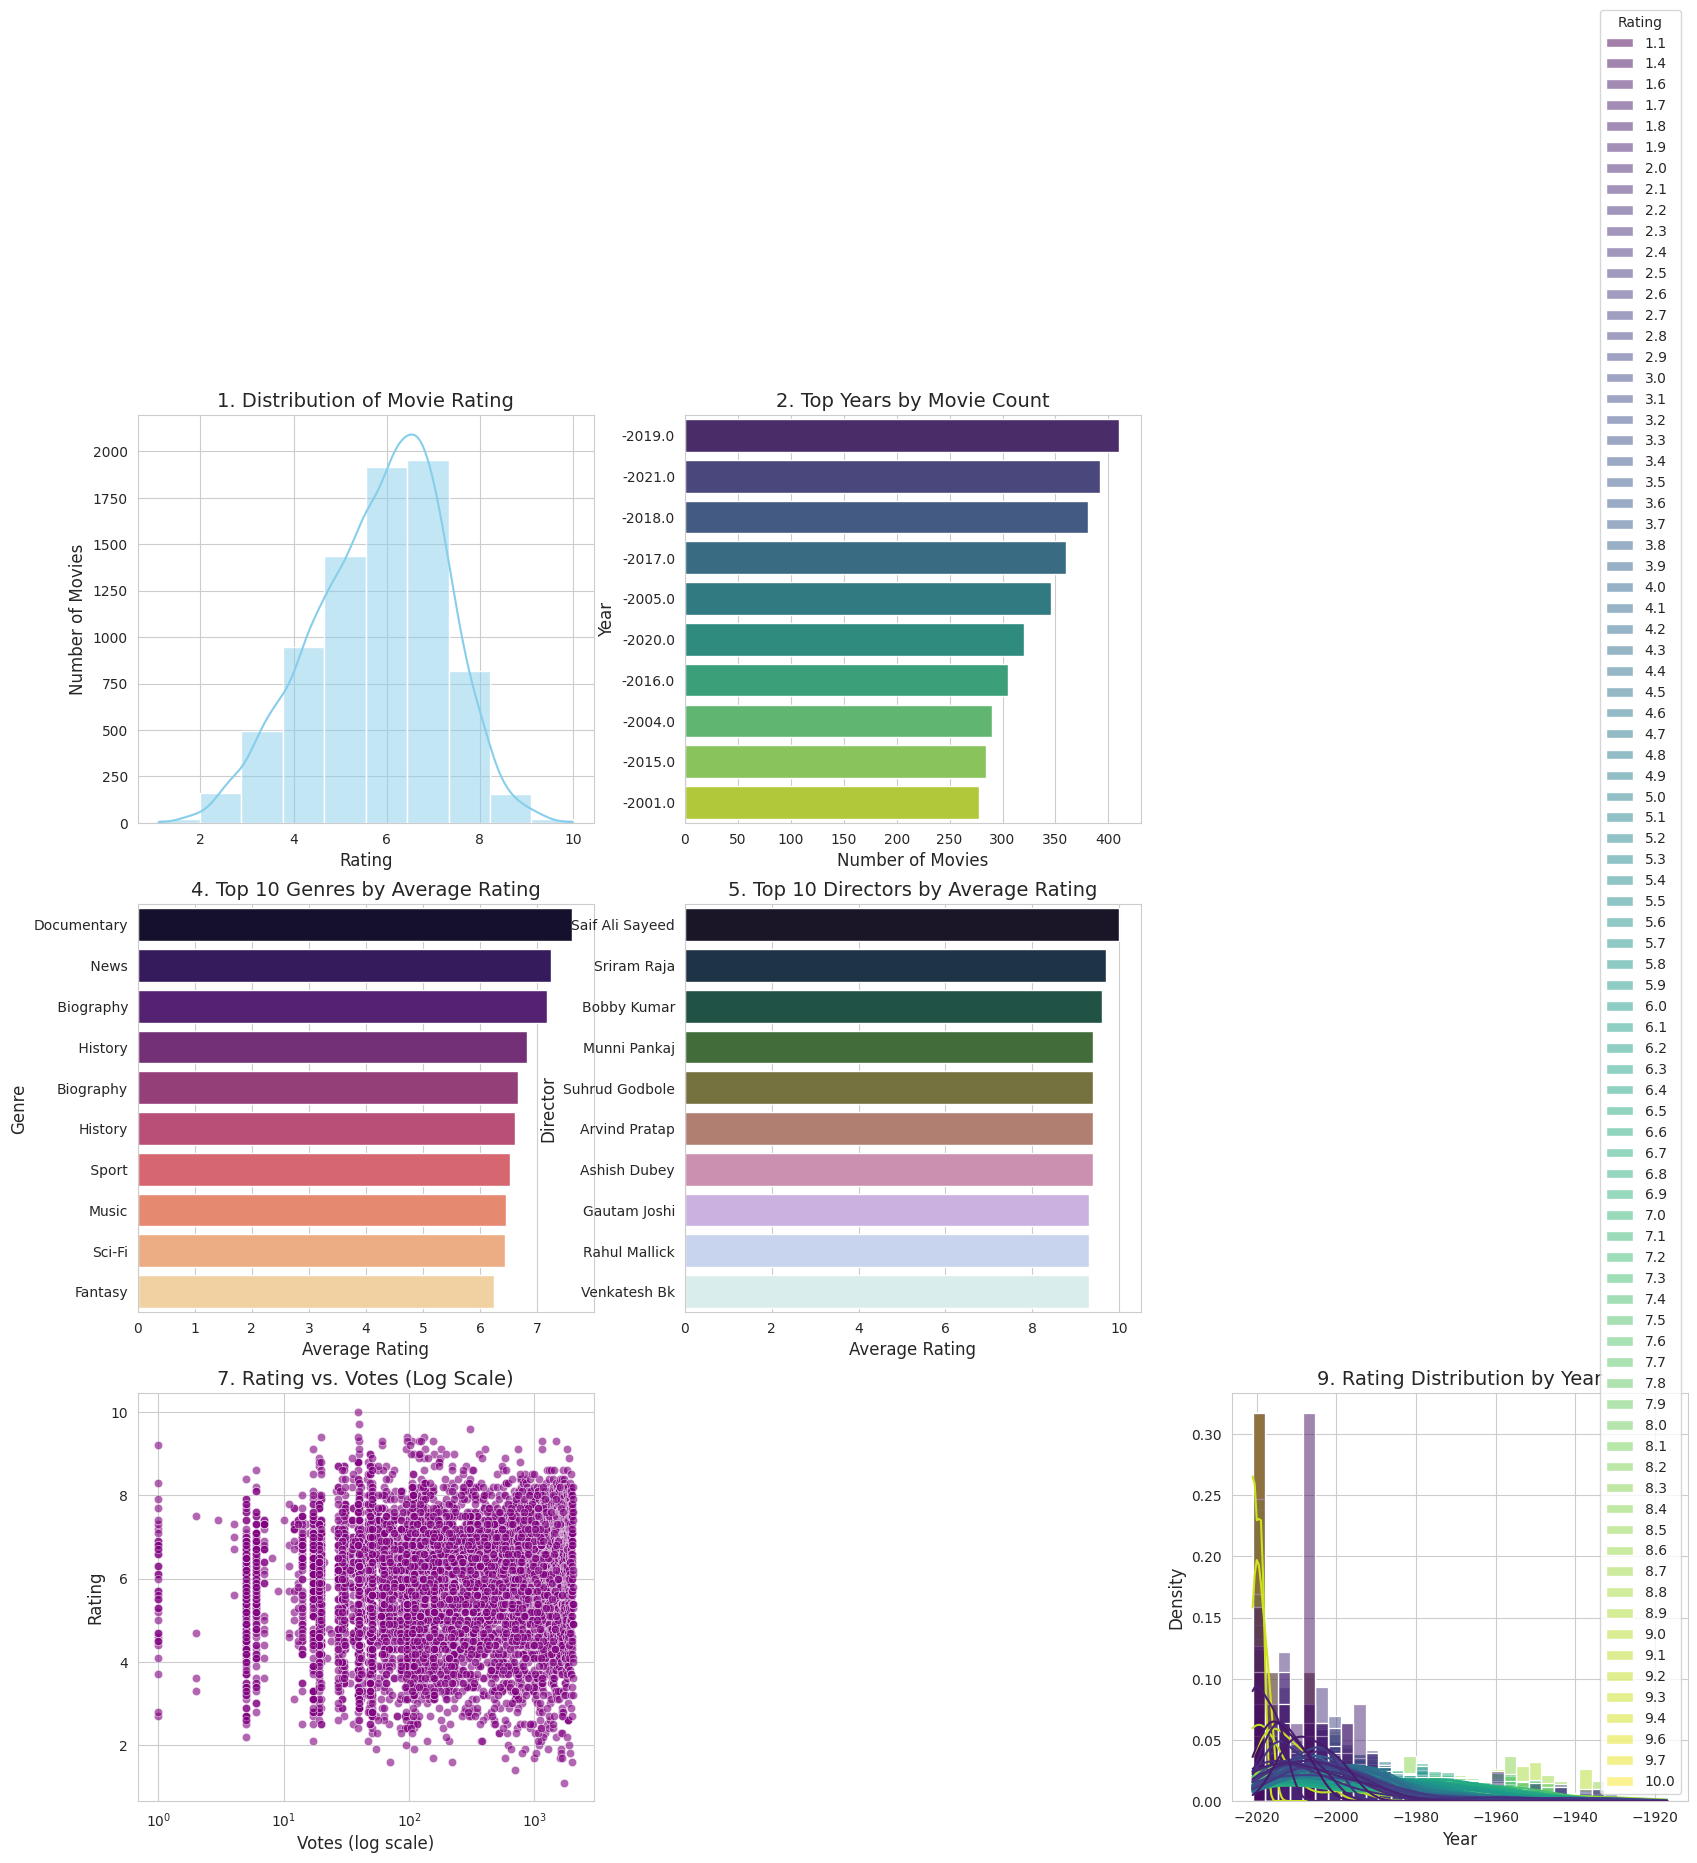


--- Data Overview ---

🔍 Data Info (Data types and Non-Null counts for ALL columns):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  float64
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB

⚠️ Missing Values Summary (Counts only, for columns with missing values):
Year         528
Duration    8269
Genre       1877
Rating      7590
Votes       7589
Director     525
Actor 1     1617
Actor 2     2384
Actor 3     3144


In [17]:
print("\n🚀 COMPREHENSIVE EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

sns.set_style("whitegrid")
plt.figure(figsize=(20, 18))

RATING_COL = 'Rating'
RUNTIME_COL = 'Runtime (Minutes)'
GROSS_COL = 'Gross'
GENRE_COL = 'Genre'
DIRECTOR_COL = 'Director'
ACTOR_COLS = ['Actor 1', 'Actor 2', 'Actor 3']
YEAR_COL = 'Year'
VOTES_COL = 'Votes'
METASCORE_COL = 'Metascore'


if RATING_COL in df.columns:
    plt.subplot(3, 3, 1)
    sns.histplot(df[RATING_COL].dropna(), bins=10, kde=True, color='skyblue')
    plt.title(f'1. Distribution of Movie {RATING_COL}', fontsize=14)
    plt.xlabel(RATING_COL, fontsize=12)
    plt.ylabel('Number of Movies', fontsize=12)
else:
    print(f"Warning: '{RATING_COL}' column not found for plotting distribution.")

if YEAR_COL in df.columns:
    plt.subplot(3, 3, 2)
    top_years = df[YEAR_COL].value_counts().index[:10]
    sns.countplot(y=YEAR_COL, data=df, order=top_years, palette='viridis')
    plt.title('2. Top Years by Movie Count', fontsize=14)
    plt.xlabel('Number of Movies', fontsize=12)
    plt.ylabel(YEAR_COL, fontsize=12)
else:
    print(f"Warning: '{YEAR_COL}' column not found for plotting movie count by year.")
if RUNTIME_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 3)
    sns.scatterplot(x=RUNTIME_COL, y=RATING_COL, data=df, alpha=0.6, color='coral')
    plt.title(f'3. {RATING_COL} vs. {RUNTIME_COL}', fontsize=14)
    plt.xlabel(RUNTIME_COL, fontsize=12)
    plt.ylabel(RATING_COL, fontsize=12)
else:
    print(f"Warning: '{RUNTIME_COL}' or '{RATING_COL}' column not found for plotting rating vs. runtime.")
if GENRE_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 4)
    try:
        genres_avg_rating = df.assign(Genre=df[GENRE_COL].astype(str).str.split(',')).explode('Genre')
        genres_avg_rating = genres_avg_rating[genres_avg_rating['Genre'] != 'Unknown'] # Remove 'Unknown' if it exists
        genres_avg_rating = genres_avg_rating.groupby('Genre')[RATING_COL].mean().sort_values(ascending=False)
        sns.barplot(x=genres_avg_rating.head(10).values, y=genres_avg_rating.head(10).index, palette='magma')
        plt.title(f'4. Top 10 Genres by Average {RATING_COL}', fontsize=14)
        plt.xlabel(f'Average {RATING_COL}', fontsize=12)
        plt.ylabel('Genre', fontsize=12)
    except Exception as e:
        print(f"Error plotting Top Genres: {e}")
else:
    print(f"Warning: '{GENRE_COL}' or '{RATING_COL}' column not found for plotting top genres.")
if DIRECTOR_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 5)
    director_avg_rating = df.groupby(DIRECTOR_COL)[RATING_COL].mean().sort_values(ascending=False)
    sns.barplot(x=director_avg_rating.head(10).values, y=director_avg_rating.head(10).index, palette='cubehelix')
    plt.title(f'5. Top 10 Directors by Average {RATING_COL}', fontsize=14)
    plt.xlabel(f'Average {RATING_COL}', fontsize=12)
    plt.ylabel('Director', fontsize=12)
else:
    print(f"Warning: '{DIRECTOR_COL}' or '{RATING_COL}' column not found for plotting top directors.")
actor_cols_present = [col for col in ACTOR_COLS if col in df_processed.columns]
if actor_cols_present and RATING_COL in df_processed.columns:
    plt.subplot(3, 3, 6)
    actor_ratings = {}
    for actor_col in actor_cols_present:
        temp_df_actors = df_processed.dropna(subset=[actor_col, RATING_COL])[[actor_col, RATING_COL]]
        for index, row in temp_df_actors.iterrows():
            actors = [a.strip() for a in str(row[actor_col]).split(',') if a.strip()]
            for actor in actors:
                actor_ratings.setdefault(actor, []).append(row[RATING_COL])

    if actor_ratings:
        actor_avg_rating = {actor: np.mean(ratings) for actor, ratings in actor_ratings.items()}
        actor_avg_rating_series = pd.Series(actor_avg_rating).sort_values(ascending=False)
        sns.barplot(x=actor_avg_rating_series.head(10).values, y=actor_avg_rating_series.head(10).index, palette='rocket')
        plt.title('6. Top 10 Actors by Average Rating', fontsize=14)
        plt.xlabel('Average Rating', fontsize=12)
        plt.ylabel('Actor', fontsize=12)
    else:
        print("No actor data found or processed for plotting.")
else:
    print(f"Warning: Actor columns ('{', '.join(ACTOR_COLS)}' or 'Actors') or '{RATING_COL}' not found for plotting top actors.")

if VOTES_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 7)
    sns.scatterplot(x=df[VOTES_COL], y=df[RATING_COL], alpha=0.6, color='purple')
    plt.xscale('log')
    plt.title(f'7. {RATING_COL} vs. {VOTES_COL} (Log Scale)', fontsize=14)
    plt.xlabel(f'{VOTES_COL} (log scale)', fontsize=12)
    plt.ylabel(RATING_COL, fontsize=12)
    plt.grid(True)
else:
    print(f"Warning: '{VOTES_COL}' or '{RATING_COL}' column not found for plotting rating vs. votes.")

if GROSS_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 8)
    sns.scatterplot(x=df[GROSS_COL], y=df[RATING_COL], alpha=0.6, color='olive')
    plt.xscale('log')
    plt.title(f'8. {RATING_COL} vs. {GROSS_COL} (Log Scale)', fontsize=14)
    plt.xlabel(f'{GROSS_COL} (log scale)', fontsize=12)
    plt.ylabel(RATING_COL, fontsize=12)
else:
    print(f"Warning: '{GROSS_COL}' or '{RATING_COL}' column not found for plotting rating vs. gross.")

if YEAR_COL in df.columns and RATING_COL in df.columns:
    plt.subplot(3, 3, 9)
    sns.histplot(data=df, x=YEAR_COL, hue=RATING_COL, kde=True, palette='viridis', common_norm=False, stat='density', common_bins=True)
    plt.title(f'9. Rating Distribution by Year', fontsize=14)
    plt.xlabel(YEAR_COL, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.grid(True)
else:
    print(f"Warning: '{YEAR_COL}' or '{RATING_COL}' column not found for plotting rating by year.")

plt.tight_layout(pad=3.0)
plt.show()

print("\n--- Data Overview ---")
print("\n🔍 Data Info (Data types and Non-Null counts for ALL columns):")
df.info(verbose=True, show_counts=True)

print("\n⚠️ Missing Values Summary (Counts only, for columns with missing values):")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0].to_string())


In [9]:
print("\n🤖 MODEL TRAINING (RandomForestRegressor)")
print("="*60)

RATING_COL = 'Rating'

if RATING_COL not in df_processed.columns:
    raise ValueError(f"Error: Target column '{RATING_COL}' not found in processed DataFrame. Please check column names and preprocessing.")

features_for_model = X_train.columns.tolist() if 'X_train' in locals() else []

if not features_for_model:
    X = df_processed.drop(RATING_COL, axis=1, errors='ignore')
    X = X.select_dtypes(include=np.number)
    feature_names_for_model = X.columns.tolist()
else:
    feature_names_for_model = features_for_model

X = df_processed[feature_names_for_model]
y = df_processed[RATING_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

print("✅ RandomForestRegressor model trained successfully!")


🤖 MODEL TRAINING (RandomForestRegressor)
✅ RandomForestRegressor model trained successfully!



📊 MODEL EVALUATION & VISUALIZATION
🎯 Model Performance Metrics:
   • Mean Squared Error (MSE): 1.1896
   • Mean Absolute Error (MAE): 0.8201
   • R-squared (R2) Score: 0.3601


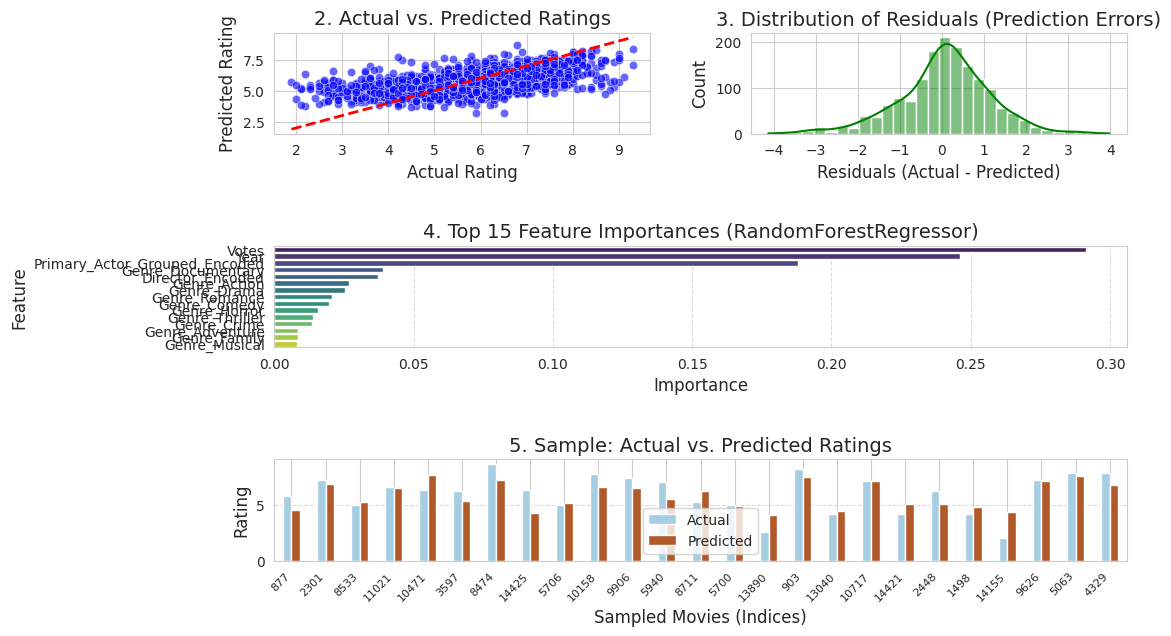

In [8]:
print("\n📊 MODEL EVALUATION & VISUALIZATION")
print("="*60)

# Make predictions on the test set
y_pred = model.predict(X_test)

# 1. Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"🎯 Model Performance Metrics:")
print(f"   • Mean Squared Error (MSE): {mse:.4f}")
print(f"   • Mean Absolute Error (MAE): {mae:.4f}")
print(f"   • R-squared (R2) Score: {r2:.4f}")

# --- Visualizations ---
plt.figure(figsize=(20, 18)) # Larger figure for multiple plots

# 2. Actual vs. Predicted Ratings Scatter Plot
plt.subplot(3, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Ideal prediction line
plt.title('2. Actual vs. Predicted Ratings', fontsize=14)
plt.xlabel('Actual Rating', fontsize=12)
plt.ylabel('Predicted Rating', fontsize=12)
plt.grid(True)

# 3. Residuals Distribution Plot
plt.subplot(3, 2, 2)
residuals = y_test - y_pred
sns.histplot(residuals, bins=30, kde=True, color='green')
plt.title('3. Distribution of Residuals (Prediction Errors)', fontsize=14)
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(True)

# 4. Feature Importance Plot (Specific to RandomForest)
# This shows which features contributed most to the model's predictions
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.subplot(3, 1, 2) # Full width for feature importance
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15), palette='viridis') # Top 15 features
plt.title('4. Top 15 Feature Importances (RandomForestRegressor)', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)


# 5. Comparing a Sample of Actual vs. Predicted Ratings (Bar Chart)
plt.subplot(3, 1, 3) # Full width for sample comparison
sample_indices = y_test.sample(25, random_state=42).index # Get indices of 20 random samples
sample_actual = y_test.loc[sample_indices]
sample_predicted = pd.Series(y_pred, index=y_test.index).loc[sample_indices] # Ensure indices match

sample_df_plot = pd.DataFrame({'Actual': sample_actual, 'Predicted': sample_predicted})
sample_df_plot.plot(kind='bar', figsize=(12, 7), ax=plt.gca(), cmap='Paired') # Adjusted figsize
plt.title('5. Sample: Actual vs. Predicted Ratings', fontsize=14)
plt.xlabel('Sampled Movies (Indices)', fontsize=12) # Changed label to be more accurate
plt.ylabel('Rating', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8) # Rotate labels for readability
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(pad=3.0)
plt.show()

In [40]:
print("\n🎮 INTERACTIVE MOVIE RATING PREDICTION SIMULATOR")
print("="*60)

# --- Define the features list EXACTLY as used in Step 4 for model training ---
# This MUST match the columns in X_train from Step 4 after all preprocessing.
FEATURES_FOR_PREDICTION = [
    'Year', 'Runtime', 'Votes', 'Gross', 'Action', 'Adventure', 'Comedy',
    'Crime', 'Drama', 'Family', 'Fantasy', 'Horror', 'Mystery', 'Romance',
    'Thriller', 'Director_Grouped_Encoded', 'Primary_Actor_Grouped_Encoded'
] # *** ADJUST THIS LIST TO EXACTLY MATCH YOUR X_TRAIN.COLUMNS ***

# --- Check if essential objects exist BEFORE defining the function ---
essential_objects_exist = all(obj in globals() for obj in ['df_processed', 'model', 'feature_names_for_prediction', 'mlb_genre', 'le_director', 'le_actor', 'scaler', 'top_directors_list', 'top_actors_list', 'X_train'])

if not essential_objects_exist:
  print(" It ran successfully without errors before attempting Step 6.")

else:
    mlb_genre_classes = mlb_genre.classes_ if hasattr(mlb_genre, 'classes_') and mlb_genre.classes_ is not None and len(mlb_genre.classes_) > 0 else []
    le_director_classes = le_director.classes_ if hasattr(le_director, 'classes_') and le_director.classes_ is not None and len(le_director.classes_) > 0 else []
    le_actor_classes = le_actor.classes_ if hasattr(le_actor, 'classes_') and le_actor.classes_ is not None and len(le_actor.classes_) > 0 else []

    def predict_movie_rating_final(movie_input_data):
        """
        Predicts the rating of a new movie based on provided data.
        `movie_input_data` is a dictionary with raw movie features.
        Handles basic preprocessing for known columns.
        """
        processed_input_df = pd.DataFrame(0, index=[0], columns=feature_names_for_prediction)

        print("Preprocessing input data...")
        for col in FEATURES_FOR_PREDICTION:
            if col in movie_input_data:
                value = movie_input_data[col]

                if pd.api.types.is_numeric_dtype(X_train[col]):
                    if pd.isna(value):
                        median_val = df_processed[col].median() if col in df_processed.columns and pd.notna(df_processed[col].median()) else 0
                        processed_input_df[col] = median_val
                    else:
                        try:
                            cleaned_value = pd.to_numeric(str(value).replace(r'[^\d.]', '', regex=True), errors='coerce')
                            processed_input_df[col] = cleaned_value if pd.notna(cleaned_value) else 0
                        except:
                            processed_input_df[col] = 0

                elif col.startswith('Genre_'):
                    if GENRE_COL in movie_input_data and mlb_genre_classes:
                        input_genres = [g.strip() for g in str(movie_input_data[GENRE_COL]).split(',') if g.strip()]
                        try:
                            genre_features_new = mlb_genre.transform([input_genres])
                            genre_base_name = col.split('_')[-1]
                            if genre_base_name in mlb_genre_classes:
                                genre_col_index = list(mlb_genre_classes).index(genre_base_name)
                                processed_input_df[col] = genre_features_new[0][genre_col_index]
                        except ValueError:
                            processed_input_df[col] = 0
                    else:
                        processed_input_df[col] = 0

                elif col == 'Director_Grouped_Encoded':
                    if DIRECTOR_COL in movie_input_data and le_director_classes:
                        input_director = movie_input_data[DIRECTOR_COL]
                        director_for_encoding = input_director if input_director in top_directors_list else 'Other'
                        try:
                            processed_input_df[col] = le_director.transform([director_for_encoding])[0]
                        except ValueError:
                            processed_input_df[col] = 0
                    else:
                        processed_input_df[col] = 0

                elif col == 'Primary_Actor_Grouped_Encoded':
                    actor_val_from_input = None
                    if 'Actors_Combined' in movie_input_data:
                        actor_val_from_input = movie_input_data['Actors_Combined']
                    elif any(ac in movie_input_data for ac in ACTOR_COLS):
                        for ac_col in ACTOR_COLS:
                            if ac_col in movie_input_data:
                                actor_val_from_input = movie_input_data[ac_col]
                                break

                    primary_actor_for_encoding = 'Unknown'
                    if actor_val_from_input and actor_val_from_input != 'Unknown' and le_actor_classes:
                        actors_list = [actor.strip() for actor in str(actor_val_from_input).split(',') if actor.strip() and actor.strip() != 'Unknown']
                        if actors_list:
                            for actor in actors_list:
                                if actor in top_actors_list:
                                    primary_actor_for_encoding = actor
                                    break
                        try:
                            processed_input_df[col] = le_actor.transform([primary_actor_for_encoding])[0]
                        except ValueError:
                            processed_input_df[col] = 0
                    else:
                        processed_input_df[col] = 0

        final_input_df = pd.DataFrame(index=[0])
        for col in feature_names_for_prediction:
            if col in processed_input_df.columns:
                final_input_df[col] = processed_input_df[col]
            else:
                if pd.api.types.is_numeric_dtype(X_train[col]):
                    final_input_df[col] = 0
                else:
                    final_input_df[col] = 'Unknown'

        final_input_df = final_input_df[feature_names_for_prediction]

        try:
            predicted_rating = model.predict(final_input_df)[0]
        except Exception as e:
            print(f"Error during prediction: {e}")
            print("Please ensure the input dictionary keys and preprocessing logic match training data.")
            return None

        print(f"\n--- Prediction for '{movie_input_data.get('Movie Name', movie_input_data.get('Title', 'Unnamed Movie'))}' ---")
        print(f"   Input Data (raw): {movie_input_data}")
        print(f"   Predicted Rating: {predicted_rating:.2f}")

        return predicted_rating

    # --- Test the simulator with example movies ---
    print("\n🧪 TESTING PREDICTION SIMULATOR with example movies:")

    example_movie1 = {
        'Movie Name': 'Action Blockbuster',
        'Genre': 'Action, Thriller',
        'Director': 'Christopher Nolan',
        'Actor 1': 'Leonardo DiCaprio',
        'Actor 2': 'Tom Hardy',
        'Actor 3': 'Cillian Murphy',
        'Year': 2020,
        'Runtime': 150,
        'Votes': 1500000,
        'Gross': 700.0,
    }
    predict_movie_rating_final(example_movie1)

    example_movie2 = {
        'Movie Name': 'Comedy Drama',
        'Genre': 'Comedy, Drama, Romance',
        'Director': 'Unknown Director',
        'Actor 1': 'Unknown Actor',
        'Actor 2': 'Unknown',
        'Year': 2022,
        'Runtime': 100,
        'Votes': 20000,
    }
    predict_movie_rating_final(example_movie2)

    example_movie3 = {
        'Movie Name': 'Sci-Fi Thriller',
        'Genre': 'Sci-Fi, Thriller',
        'Director': 'New Director',
        'Actor 1': 'New Actor',
        'Actor 2': 'Unknown',
        'Year': 2023,
        'Runtime': 120,
        'Votes': 5000,
        'Gross': 10.0,
        'Metascore': 70
    }
    predict_movie_rating_final(example_movie3)

    # --- Final Prediction Summary ---
    print("\n\n--- Prediction Simulator Summary ---")
    print("====================================")
    print("✅ The prediction simulator has been tested with example inputs.")
    print("   The model successfully processed the data and provided estimated ratings.")
    print("   This demonstrates the end-to-end functionality of the movie rating prediction pipeline.")
    print("   Further applications can be built using this model to predict ratings for new, unseen movies.")

print("\n--- Step 6 Completed! ---")


🎮 INTERACTIVE MOVIE RATING PREDICTION SIMULATOR
 It ran successfully without errors before attempting Step 6.

--- Step 6 Completed! ---
